# About descriptives_sequence_analysis

This notebook runs descriptives and clustering analysis on sequence actions.

In [1]:
%load_ext autoreload
%autoreload 1
%aimport utils_read_parsing
%aimport utils_timeline_viz
%aimport utils_sequence_parsing
from utils_read_parsing import *
from utils_timeline_viz import *
from utils_sequence_parsing import converter, Sequence
import os
import numpy as np
import pandas as pd
import getpass
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
pd.set_option('display.max_columns', None);pd.set_option('display.max_rows', None);pd.set_option('precision', 2)
%matplotlib inline
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = 12,4

# Loading student and sequence data

In [2]:
log_files_per_sim = {}
for sim in ['beers','capacitor']:
    log_files_per_sim[sim] = get_parsed_log_files_per_student_for_sim(sim)

The file Sarah_beers_log_files_per_student.txt has been unpickled and loaded
The file Sarah_capacitor_log_files_per_student.txt has been unpickled and loaded


In [3]:
df_all = get_df_all_factors()

In [4]:
ids = list(set(df_all['sid']))
N = len(ids)
print N

147


In [5]:
import pickle
pickle_in_seqs = open(os.path.join(BIG_FOLDER,'all_massaged_data\\dict_by_sim_by_student_parsed_seqs.txt'),"r")
all_seqs = pickle.load(pickle_in_seqs)
pickle_in_seqs.close()

# Descriptives of blocked seqs

## Tranform sequences

In [6]:
%%time
transformed_seqs = {}
for sim,seqs_by_student in all_seqs.iteritems():
    transformed_seqs[sim] = {}
    for sid,seq in seqs_by_student.iteritems():
        seq.remove_actions('ignore')
        seq.merge_actions(['P','P_notes'])
        seq.block_actions(['P','V_area', 'V_battery', 'V_lightbulb', 'V_separation','V_other','V_width','V_concentration','V_wavelength','V_detector','V_laser','V_ruler'])
        seq.check_lengths_seq_timecoords()
        transformed_seqs[sim][sid] = seq

Wall time: 148 ms


## Test on 1 student

In [7]:
# sim = 'beers'
# to_plot = to_plot_beers
# test_sid = 19989152
# df = prep_parsing_data(log_files_per_sim[sim][test_sid][0]) 
# plt.figure(figsize=(15,7))
# plot(df,to_plot,family_name_to_code,function_to_use,colors)

In [8]:
# transformed_seqs[sim][test_sid]

## Individual actions

We care about:
1. how many sequences the action is found in,
2. how many times it's used byt students.
-> histogram start at counts of 1 not zero.

In [9]:
nb_use = {}
for sim in ['beers','capacitor']:
    for student, seq in transformed_seqs[sim].iteritems():
        for a in seq.actions:
            if a not in nb_use.keys():
                nb_use[a] = []
            nb_use[a].append(seq.seq.count(a))
actions = nb_use.keys()
actions.sort()

In [10]:
# fig,axes = plt.subplots(nrows=len(actions),ncols=1,figsize=(10,4*len(actions)))
# for i,a in enumerate(actions):
#     ax=axes[i]
#     (n, bins, patches) = ax.hist(nb_use[a],bins=range(max(nb_use[a])))
#     ax.set(title='Distribution of action "{0}" used in {1} sequences'.format(a,len(nb_use[a])))
#     ax.set(ylabel='Number of sequences')

In [11]:
from matplotlib.backends.backend_pdf import PdfPages
with PdfPages('seq_actions_hist_both_sims.pdf') as pdf:
    for i,a in enumerate(actions):
        plt.hist(nb_use[a],bins=range(max(nb_use[a])))
        plt.title('Hist of number of episodes for "{0}" found in {1} sequences'.format(a,len(nb_use[a])))
        plt.ylabel('Number of sequences')
        plt.tight_layout()
        pdf.savefig()
        plt.close()

## Lengths

In [12]:
nb_actions = []
lengths = []
for sim in ['beers','capacitor']:
    for student, seq in transformed_seqs[sim].iteritems():
        nb_actions.append(len(seq.seq))
        lengths.append(seq.timecoords[-1])

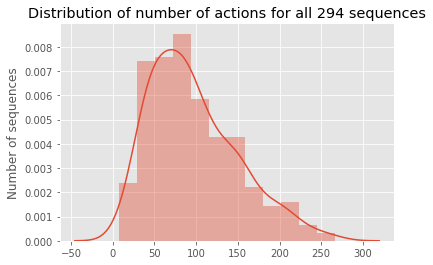

In [29]:
sns.distplot(nb_actions)
plt.title('Distribution of number of actions for all {0} sequences'.format(N*2))
plt.ylabel('Number of sequences');

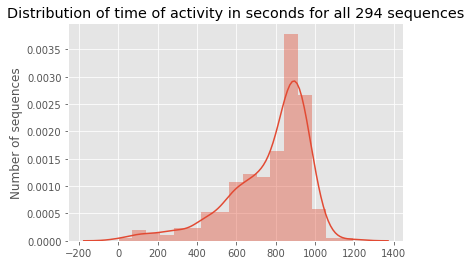

In [28]:
sns.distplot(lengths)
plt.title('Distribution of time of activity in seconds for all {0} sequences'.format(N*2))
plt.ylabel('Number of sequences');

## When do they pause?

Need ot normalize by 1) frequency of action and 2) number of pauses per student

* for each sequence find # of times action A before P
* divide by number of P
* get a percentage
* then normalize by overall frequency of action in all sequences???

In [15]:
freq_beforeP = {key:[] for key in actions}
freq_afterP = {key:[] for key in actions}
all_actions = []
for a in actions:
    for sim in ['beers','capacitor']:
        for student, sequence in transformed_seqs[sim].iteritems():
            count_beforeP = sum([1 for i, s in enumerate(sequence.seq) if s == 'P' and sequence.seq[i-1]==a])
            afterP = [sequence.seq[i+1] for i, s in enumerate(sequence.seq) if s == 'P' and i!=len(sequence.seq)-1]
            count_afterP = sum([1 for s in afterP if s==a])
            number_P = float(sequence.seq.count('P'))
            freq_beforeP[a].append(count_beforeP/number_P)
            freq_afterP[a].append(count_afterP/number_P)
            all_actions.extend(sequence.seq)

counts_all_actions = {a:all_actions.count(a) for a in set(all_actions)}
score_beforeP = [(a,np.mean(freq_beforeP[a])/float(counts_all_actions[a])) for a in actions]
score_afterP = [(a,np.mean(freq_afterP[a])/float(counts_all_actions[a])) for a in actions]
score_beforeP.sort(key = lambda t: t[1],reverse=True)
score_afterP.sort(key = lambda t: t[1],reverse=True)

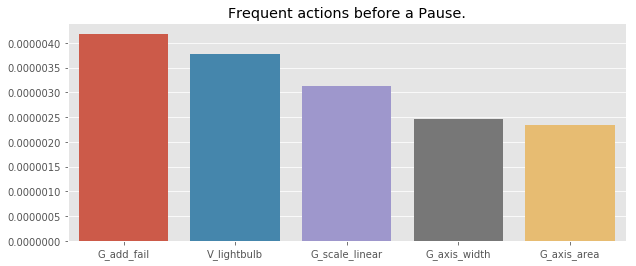

In [23]:
plt.figure(figsize=(10,4))
sns.barplot(x=list(zip(*score_beforeP[:5])[0]),y=list(zip(*score_beforeP[:5])[1]))
plt.title('Frequent actions before a Pause.');

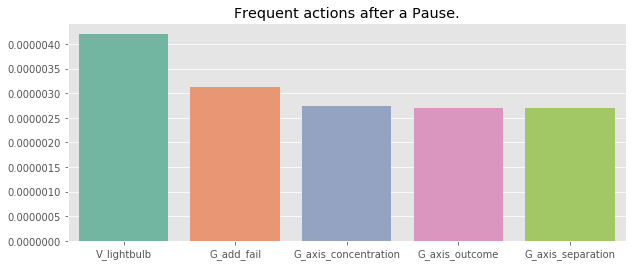

In [24]:
plt.figure(figsize=(10,4))
sns.barplot(x=list(zip(*score_afterP[:5])[0]),y=list(zip(*score_afterP[:5])[1]),palette="Set2")
plt.title('Frequent actions after a Pause.');

Observations:
* Clearly playing with the lightbulb elicits both planning and reflection.
* Students often pause before and after a Graph action: either because they need to figure out how to make a graph (Graph_add_fail) or they just changed the axes
* Student often pause after making an axis linear, or in other words after manipulating axis scales in general. Probably because they are interpreting their graph.

## Testing variable changing

In [155]:
from itertools import groupby
import re

class Sequence():
#     actions = set()
#         actions.update(self.seq)
    
    def __init__(self,seq, sid=None, sim=None, timecoords=None):
        '''Store a sequence of actions for a particular student (sid)
            in a particular simulation (sim) and optionally with 
            time coordinates for each action'''
        self.seq = seq
        self.sid = sid
        self.sim = sim
        self.timecoords = timecoords
        self.actions = set()
        self.update_actions() #save a list of unique actions
        self.blocked_actions = set()
        self.removed_actions = set()
        self.sets_merged_actions = set()
        if timecoords:
            self.check_lengths_seq_timecoords()

    def __repr__(self):
        return "Sequence({0})".format(','.join(self.seq))
    
    def update_actions(self):
        self.actions = set(self.seq)
        
    def set_timecoords(self, timecoords):
        '''Sets the time coordinates for every action in the sequence'''
        self.timecoords = timecoords
        self.check_lengths_seq_timecoords()
        return self
    
    def extend_seq(self,seq_to_add,timecoords_to_add=None):
        '''Adding actions at the end of the sequence,
            and optinally the cooresponding time coordinates'''
        self.seq.extend(seq_to_add)
        self.update_actions()
        if timecoords_to_add:
            self.extend_timecoords(timecoords_to_add)
            self.check_lengths_seq_timecoords()
        return self
    
    def extend_timecoords(self,timecoords_to_add):
        '''Adding timecoordinates'''
        self.timecoords.extend(timecoords_to_add)
        self.check_lengths_seq_timecoords()
        return self
        
    def remove_actions(self,actions_to_remove):
        '''Remove 1 action or multiple actions'''
        #check if we are removing 1 or a list of actions
        if isinstance(actions_to_remove,basestring):
            actions_to_remove = [actions_to_remove]
        self.removed_actions.update(actions_to_remove)
        
        if self.timecoords:
            zipped = zip(self.seq,self.timecoords)
            new_zipped = [(s,t) for s,t in zipped if s not in actions_to_remove]
            #unzip using map(list, _) to return a list not a tuple
            self.seq, self.timecoords = map(list, zip(*new_zipped))
            self.check_lengths_seq_timecoords()
        else:
            self.seq = [s for s in self.seq if s not in actions_to_remove]
            
        #we update the list of unique actions
        self.update_actions()
        
        #we rerun blocking of actions if it was run before
        if self.blocked_actions:
            self.block_actions(self.blocked_actions)
        return self
     
    def block_actions(self,actions_to_block=None):
        '''Block 1 or multiple actions'''
        #If none specified, block all actions
        if actions_to_block == None:
            actions_to_block = self.actions
        #If one specified, turn to a list
        elif isinstance(actions_to_block,basestring):
            actions_to_block = [actions_to_block]
        self.blocked_actions.update(actions_to_block)
        
        self.unblocked_seq = list(self.seq) #make a copy
        self.seq = []

        if self.timecoords:
            updating_timecoords = True
            self.unblocked_timecoords = list(self.timecoords)
            self.timecoords = []
        else:
            updating_timecoords = False
        
        i=0 #index of where we are in the sequence
        for key,group in groupby(self.unblocked_seq):
            group_copy = list(group) #make a copy because it's a generator element?
            if key in actions_to_block:
                #append the one blocked action
                self.seq.append(key)
                if updating_timecoords:
                    self.timecoords.append(self.unblocked_timecoords[i])
            else:
                #append the entire group of actions of the same type
                self.seq.extend(group_copy)
                if updating_timecoords:
                    self.timecoords.extend(self.unblocked_timecoords[i:i+len(group_copy)])
            #update index
            i = i + len(group_copy)
            
        if updating_timecoords:
            self.check_lengths_seq_timecoords()
        return self
    
    def check_lengths_seq_timecoords(self):
        '''Checks that we have a time coordinate for every aciton the sequence'''
        if len(self.seq)>len(self.timecoords):
            raise ValueError('There are more sequence actions than time coordinates')
        if len(self.seq)<len(self.timecoords):
            raise ValueError('There are more time coordinates than sequence actions')

    def merge_actions(self,actions_to_merge,merged_action_name=None):
        '''Takes list of actions and replaces each instance of
            these actions with a new name. If no name provided, use first action in list'''
        if merged_action_name == None:
            merged_action_name = actions_to_merge[0]
        if len(actions_to_merge)<2:
            raise ValueError('Please provide at least 2 actions to merge.')
        self.sets_merged_actions.add(tuple(actions_to_merge))
        self.unmerged_sequence = list(self.seq)
        self.seq = [merged_action_name if s in actions_to_merge else s for s in self.unmerged_sequence]
        
        #if merged actions were previously blocked, we rerun blocking
        if set(self.blocked_actions) & set(actions_to_merge):
            self.block_actions(self.blocked_actions)
        self.update_actions()
        return self        

    def translate_variable_actions(self):
        regex_pattern_var = re.compile('[VG\_]+(?:axis\_)?([a-z]+)')
        old_seq = list(self.seq)
        self.seq = []
        current_quant = None
        number_switches = 0 #need to track so we put
        # "Switch_quant" action at the right time coordinate
        for i,s in enumerate(old_seq):
            if 'V_' in s or 'G_axis_' in s:
                var = regex_pattern_var.match(s).group(1)
                action = s
                action = action.replace(var,'')
                if var in ['wavelength','battery']:
                    #translate qual variable
                    self.seq.append(action+'qual')
                elif var not in ['area', 'separation','width','concentration']:
                    #variable is some other (lightbulb, detector, ruler...)
                    #so we don't change the action
                    self.seq.append(action+var)
                elif current_quant == None:
                    #translate quant variable
                    #first quant variable encountered
                    current_quant = var
                    self.seq.append(action+'quant')
                elif var == current_quant:
                    #previous action and current action on same quant variable
                    self.seq.append(action+'quant')
                else:
                    #previous action and current action are different
                    # so we note the change with a new action
                    self.seq.extend(['Switch_quant',action+'quant'])
                    current_quant = var
                    #need to add a timecoord for this new "action"
                    if self.timecoords!=None:
                        self.timecoords.insert(i+number_switches,self.timecoords[i+number_switches]-0.0001)
                    number_switches += 1
            else:
                self.seq.append(s)
        self.update_actions()
        if self.timecoords!=None:
            self.check_lengths_seq_timecoords()
        return self


    def parameters(self):
        '''Prints the parameters of the sequence including previous tranformations'''
        to_print = 'Length:{} actions, sid:{}, sim:{}, blocked actions:{},'.format(len(self.seq),self.sid,self.sim,self.blocked_actions)
        to_print += 'actions removed: {}, merged_actions: {}, has timecoords: {}'.format(self.removed_actions,self.sets_merged_actions,self.timecoords!=None)
        print to_print

In [156]:
original = ['V_concentration','V_width','G_axis_concentration']
coords = range(len(original))
S = Sequence(original,timecoords=coords)
S.translate_variable_actions();
for a,b in zip(S.timecoords,zip(S.seq+[''],original+['','','',''])):
    print a,b

0 ('V_quant', 'V_concentration')
0.9999 ('Switch_quant', 'V_width')
1 ('V_quant', 'G_axis_concentration')
1.9999 ('Switch_quant', '')
2 ('G_axis_quant', '')
